#### PLOT FIGURE 1 OF MDCATH PAPER

In [5]:
import os 
import textwrap
import pandas as pd
from os.path import join as opj
from tqdm.notebook import tqdm
from moleculekit.molecule import Molecule
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
initial_data = pd.read_table('/workspace7/toni_cath/cath_downloads/non-redundant-data-sets/cath-dataset-nonredundant-S20.list', header=None, names=['domain'])
initial_data = list(initial_data['domain'])
start_domains = len(initial_data)
print('Initial number of domains: ', start_domains)

Initial number of domains:  14433


##### CHECK THE NUMBER OF RESIDUES IN THE PROTEIN

In [3]:
from glob import glob
def readPDBs(pdbFileList):
    pdblist = []
    with open(pdbFileList, "r") as f:
        for line in f:
            pdblist.append(line.strip())
    return sorted(pdblist)

""" Reasons for "bad" files which are excluded from the dataset and not present in good_domains: 
 - modified residues in original PDB
 - unresolved regions in   ''    '' 
 
 """
good_domains = readPDBs('/shared/antoniom/buildCATHDataset/accetptedPDBs.txt')
num_good_domains = len(good_domains)
final_data = len(glob('/workspace7/antoniom/mdCATH/*/*.h5'))

print('Number of good domains: ', num_good_domains)
print('Number of final domains: ', final_data)

Number of good domains:  5398
Number of final domains:  5398


In [4]:
# read a log file of build script
import re
pdb_ids_tuple = tuple(initial_data)
cubic_box_failing = {}
residues_out_of_range = {}
unknown_residues = {}
fine_domains = []
segment_chain_error = []
pdb_input_error = []
sulphur_atoms_error = []
computation_error = {}

box_err_test_pattern = pattern = r"[-+]?\d*\.\d+|\d+"
unknown_residues_pattern = r"\['[^]]*'\]"
num_res_pattern = r"\b\d+\b"
with open('/workspace7/toni_cath/build_failures.log', 'r') as f:
    failed_domains = f.readlines()
    for i, line in tqdm(enumerate(failed_domains), total=start_domains):
        if not line.startswith(pdb_ids_tuple):
            continue
        pdb = line.split(":")[0].strip()
        status = line.split(":")[1].strip()
        if status == 'OK':
            fine_domains.append(pdb)
        elif 'Cubic box' in status:
            box_matches = re.findall(box_err_test_pattern, status)
            cubic_box_failing[pdb] = float(box_matches[0])
        elif 'UnknownResidueError' in status:
            err_res_matches = re.findall(unknown_residues_pattern, status)
            unknown_residues[pdb] = err_res_matches
        elif 'residues, out of range' in status:
            num_res_matches = re.findall(num_res_pattern, status)
            residues_out_of_range[pdb] = int(num_res_matches[0])
        elif 'No chains or segments defined in Molecule.chain / Molecule.segid' in status:
            segment_chain_error.append(pdb)
        elif status == 'DEBUG INFO' or 'Element X was read in file' in status:
            pdb_input_error.append(pdb)
        elif 'Sulphur atoms between pairs' in status:
            sulphur_atoms_error.append(pdb)
        elif 'operands could not be broadcast together' in status or 'list index out of range':
            computation_error[pdb] = status
        else:
            print(f'Unknown status for {pdb} \nexiting with: {status}')
            break

print('Number of fine domains: ', len(fine_domains))
print('Number of domains with cubic box error: ', len(cubic_box_failing))
print('Number of domains with unknown residues: ', len(unknown_residues))
print('Number of domains with segment/chain error: ', len(segment_chain_error))
print('Number of domains with PDBInputError: ', len(pdb_input_error))
print('Number of domains with computation error: ', len(computation_error))
print('Number of domains with sulphur atoms error: ', len(sulphur_atoms_error))
print('Number of domains with residues out of range: ', len(residues_out_of_range))

  0%|          | 0/14433 [00:00<?, ?it/s]

Number of fine domains:  12667
Number of domains with cubic box error:  255
Number of domains with unknown residues:  340
Number of domains with segment/chain error:  5
Number of domains with PDBInputError:  192
Number of domains with computation error:  4
Number of domains with sulphur atoms error:  7
Number of domains with residues out of range:  963


In [28]:
bad_domains = readPDBs('/workspace7/toni_cath/9b_bad.txt')

# Calculating the cumulative number of domains remaining after each error type
remaining_after_errors = [start_domains,
                        start_domains - len(residues_out_of_range), 
                        start_domains - len(residues_out_of_range) - len(bad_domains) - len(unknown_residues) - len(segment_chain_error), 
                        start_domains - len(residues_out_of_range) - len(bad_domains) - len(unknown_residues) - len(segment_chain_error) - len(pdb_input_error) - len(sulphur_atoms_error) - len(computation_error),
                        start_domains - len(residues_out_of_range) - len(bad_domains) - len(unknown_residues) - len(segment_chain_error) - len(pdb_input_error) - len(sulphur_atoms_error) - len(computation_error) - len(cubic_box_failing),
                        final_data
                    ]

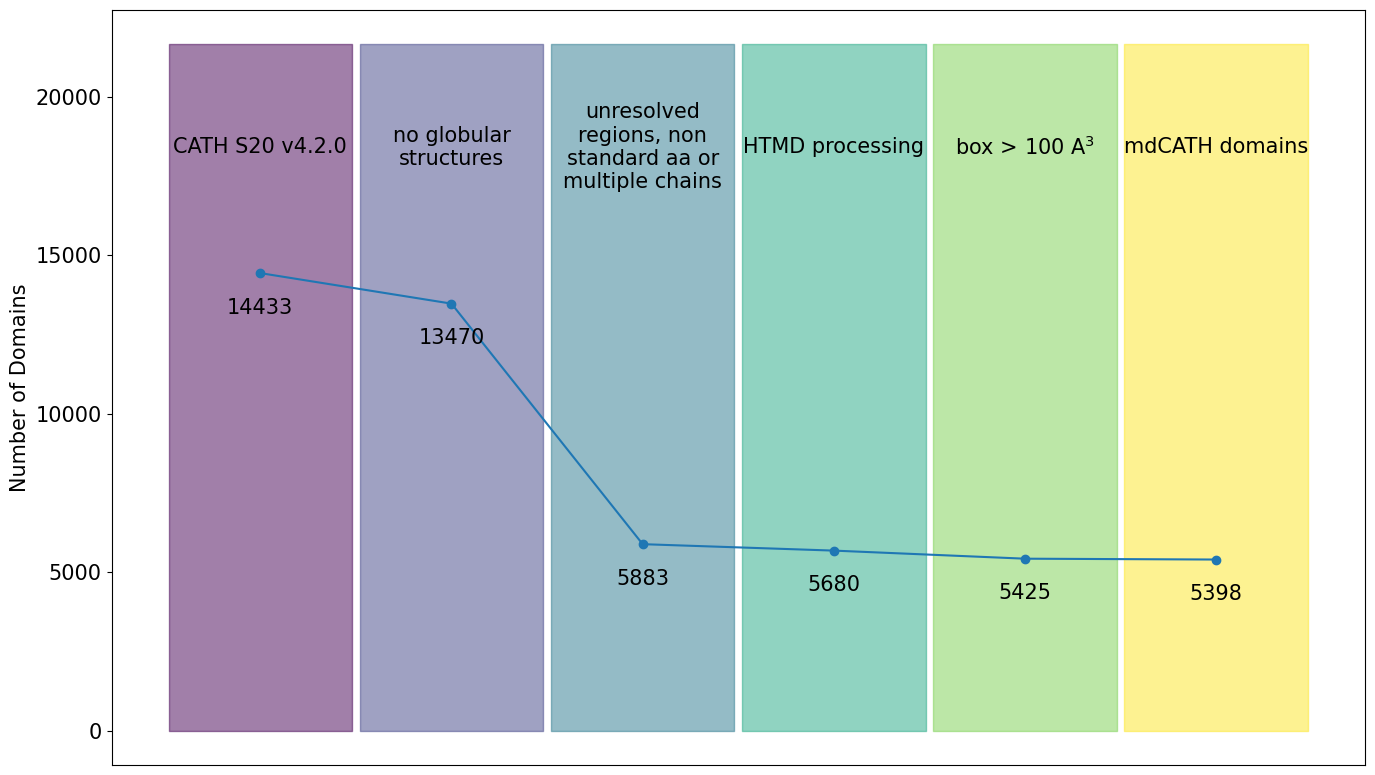

In [8]:
categories = ['CATH S20 v4.2.0', 'no globular structures', 'unresolved regions, non standard aa or multiple chains', 'HTMD processing', 
              f'box > 100 A$^{3}$', 'mdCATH domains']

# Configuration
color_alpha = 0.5
text_width = 18 # Maximum width in characters for wrapped text

# Create a color palette
colors = plt.cm.viridis(np.linspace(0, 1, len(categories)))

plt.figure(figsize=(14, 8))
x_values = np.arange(len(categories))
# set fontsize
plt.rcParams.update({'font.size': 15})
# Plot the line connecting all points
plt.plot(x_values, remaining_after_errors, marker='o')
y_min, y_max = 0, max(remaining_after_errors) * 1.5
# Overlay non-attached colored areas for each category and add wrapped text
for i, (color, category) in enumerate(zip(colors, categories)):
    # Define start and end of the colored area with some spacing
    start = x_values[i] - 0.48
    end = x_values[i] + 0.48
    plt.fill_betweenx([y_min, y_max], start, end, color=color, alpha=color_alpha)

    # Wrap text to fit into the colored area
    wrapped_text = textwrap.fill(category, text_width)
    plt.text(x_values[i], y_max * 0.85, wrapped_text, ha='center', va='center', color='black')
    # annotate the number of domains
    plt.text(x_values[i], remaining_after_errors[i] - 0.065 * y_max, remaining_after_errors[i], ha='center', va='bottom', color='black')
plt.xticks(ticks=x_values, labels=categories, rotation=45, ha='right')
plt.ylabel('Number of Domains')
plt.xticks([])
plt.tight_layout()
plt.savefig('figures/domain_selection.png', dpi=600)
plt.show()

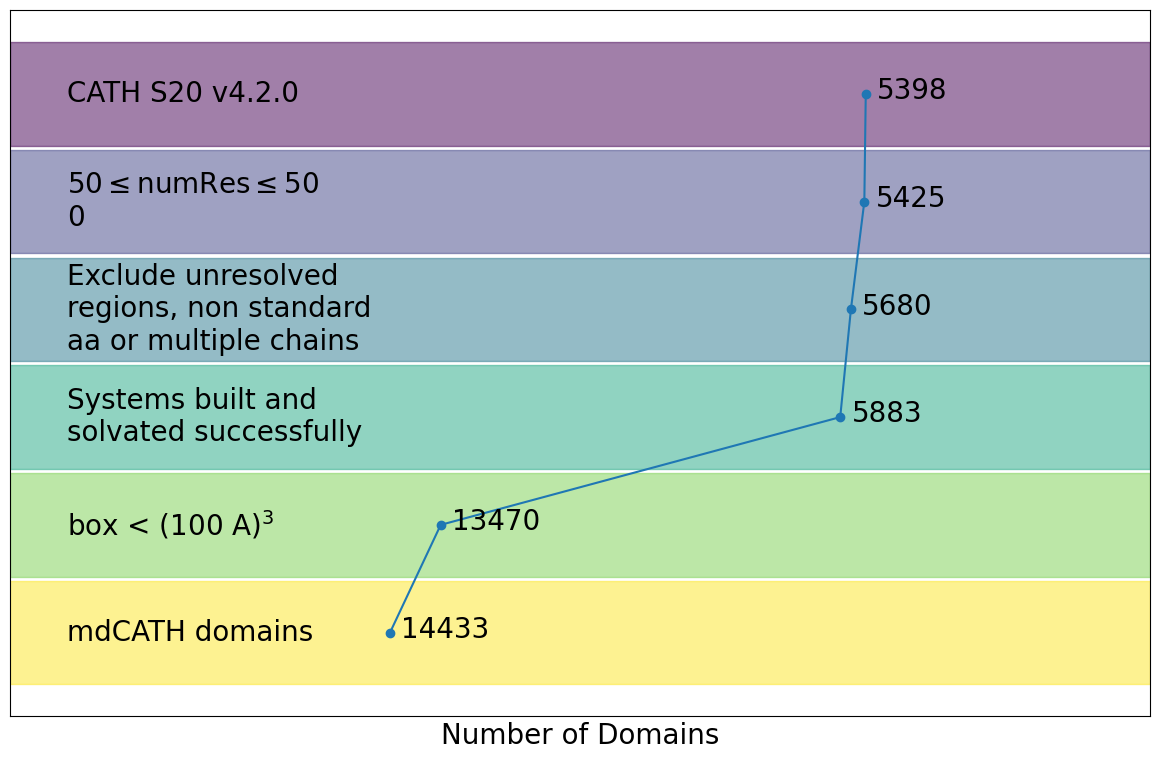

In [12]:
categories = ['CATH S20 v4.2.0', r'50$\leq$numRes$\leq$500', 'Exclude unresolved regions, non standard aa or multiple chains', 'Systems built and solvated successfully', 
              r'box < (100 A)$^{3}$', 'mdCATH domains']

color_alpha = 0.5
text_width = 21  # Maximum width in characters for wrapped text
revert_remaining_after_errors = remaining_after_errors[::-1]
# Create a color palette
colors = plt.cm.viridis(np.linspace(0, 1, len(categories)))

plt.figure(figsize=(12, 8))
y_values = np.arange(len(categories))
# Set fontsize
plt.rcParams.update({'font.size': 20})

# Plot the line connecting all points horizontally
plt.plot(revert_remaining_after_errors, y_values, marker='o')

# Set x limits to a reasonable range based on the data
x_min, x_max = 0, max(remaining_after_errors) * 1.5
plt.xlim(x_max, x_min)

# Overlay non-attached colored areas for each category and add wrapped text
for i, (color, category) in enumerate(zip(colors[::-1], categories[::-1])):
    # Define start and end of the colored area with some spacing
    start = y_values[i] - 0.48
    end = y_values[i] + 0.48
    plt.fill_betweenx([start, end], x_min, x_max, color=color, alpha=color_alpha)

    # Wrap text to fit into the colored area
    wrapped_text = textwrap.fill(category, text_width)
    plt.text(x_max * 0.95, y_values[i], wrapped_text, va='center', color='black')
    
    # Annotate the number of domains
    plt.text(revert_remaining_after_errors[i] - 0.01 * x_max, y_values[i]+0.025, revert_remaining_after_errors[i], va='center', color='black')

plt.xlabel('Number of Domains')
plt.yticks([])
plt.xticks([])
plt.tight_layout()
plt.savefig('figures/domain_selection_horizontal.png', dpi=600)
plt.show()

In [27]:
remaining_after_errors

[5398, 5425, 5680, 5883, 13470, 14433]

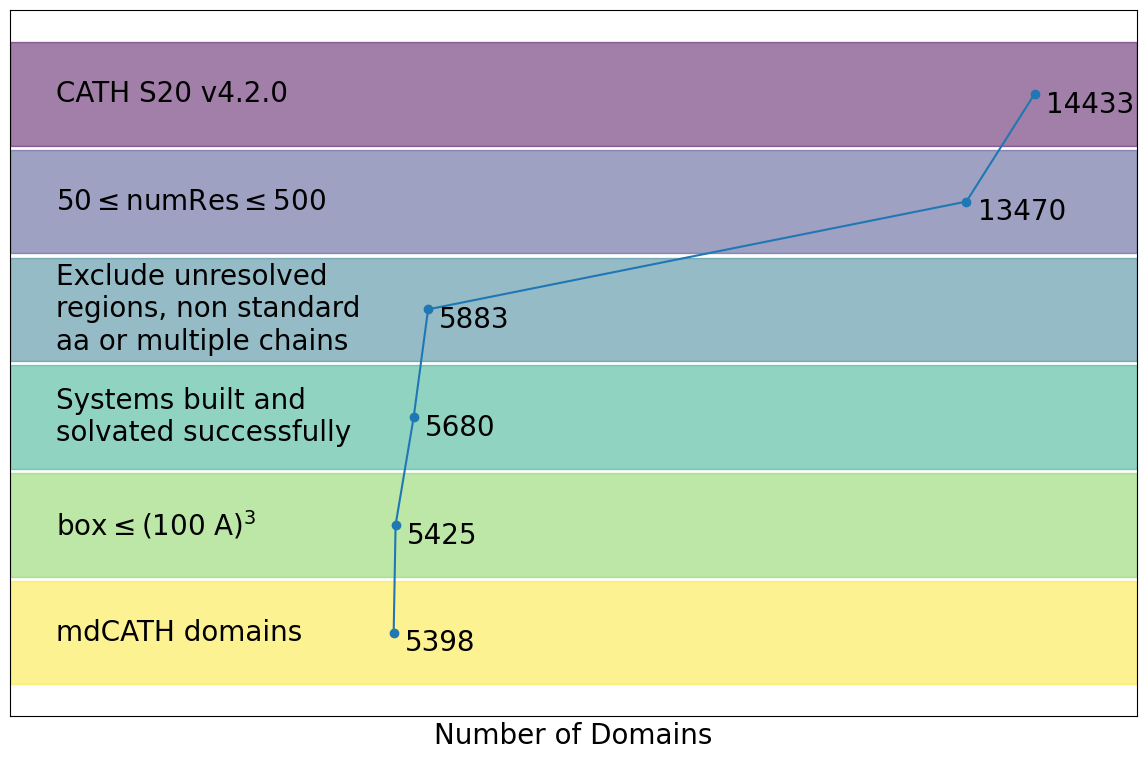

In [46]:
categories = ['CATH S20 v4.2.0', r'50$\leq$numRes$\leq$500', 'Exclude unresolved regions, non standard aa or multiple chains', 'Systems built and solvated successfully', 
              r'box$\leq$(100 A)$^{3}$', 'mdCATH domains']

color_alpha = 0.5
text_width = 23 # Maximum width in characters for wrapped text

colors = plt.cm.viridis_r(np.linspace(0, 1, len(categories)))

categories = categories[::-1]
revert_remaining_after_errors = remaining_after_errors[::-1]
plt.figure(figsize=(12, 8))
y_values = np.arange(len(categories))
# Set fontsize
plt.rcParams.update({'font.size': 20})

# Plot the line connecting all points horizontally
plt.plot(revert_remaining_after_errors, y_values, marker='o')

# Set x limits to a reasonable range based on the data
x_min, x_max = -10, max(revert_remaining_after_errors) * 1.1
plt.xlim(x_min, x_max)

# Overlay non-attached colored areas for each category and add wrapped text
for i, (color, category) in enumerate(zip(colors, categories)):
    # Define start and end of the colored area with some spacing
    start = y_values[i] - 0.48
    end = y_values[i] + 0.48
    plt.fill_betweenx([start, end], x_min, x_max, color=color, alpha=color_alpha)

    # Wrap text to fit into the colored area
    wrapped_text = textwrap.fill(category, text_width)
    plt.text(x_max * 0.04, y_values[i], wrapped_text, va='center', color='black')
    
    # Annotate the number of domains
    plt.text(revert_remaining_after_errors[i] + 0.01 * x_max, y_values[i]-0.1, revert_remaining_after_errors[i], va='center', color='black')

plt.xlabel('Number of Domains')
plt.yticks([])
plt.xticks([])
plt.tight_layout()
plt.savefig('figures/domain_selection_horizontal_revert.png', dpi=600)
plt.show()